<a href="https://colab.research.google.com/github/Gio1709/paddy_100m_new/blob/master/Identifikasi_Lahan_Pertanian_100m_dan%20Perbandingan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDENTIFIKASI VEGETASI OTOMATIS DENGAN GAMBAR GOOGLE EARTH MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK**

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image.

Sedangkan pada penelitian ini memiliki konsep yang serupa dengan penelitian sebelumnya, akan tetapi mengambil sampel yang dilakukan lahan persawahan di Kabupaten Banyumas. 

Peneliti : Fendy Prayogi

Repositori tersedia pada : https://github.com/Gio1709/paddy


# Mengimpor/Mengambil Fungsi Library

In [10]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
import pandas as pd
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



# Mengambil Dataset dari Github

In [3]:
# Mengambil dataset dari github

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_100/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy-coba/trunk/data/ > /dev/null 

!apt-get install subversion > /dev/null
!svn export https://github.com/Gio1709/paddy_100m_new/trunk/data/ > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300m_new/trunk/data/ > /dev/null 

#!wget https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip paddy.zip
#!unzip -P paddy paddy.zip


svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'data' already exists


**Persiapan :**

*Program ini dibuat untuk mengidentifikasi lahan sawah dan luas di Kabupaten Banyumas*

File tersimpan dalam folder :
1. */chopped*
2. */train*
3. */test* 

# Mengimpor Datasheet

In [4]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Github

!ls data/paddy/train
!ls data/paddy/train/Jawa
!ls data/paddy/train/Kalimantan
!ls data/paddy/train/Sumatra
#gambar dengan nama awalan dengan "b" adalah gambar yang terdapat padi"
#gambar dengan nama awalan dengan "o" adalah gambar yang tidak terdapat padi"

Jawa  Kalimantan  Sumatra
b51.jpg  b57.jpg  b63.jpg  b69.jpg  b75.jpg  o56.jpg  o62.jpg  o68.jpg	o74.jpg
b52.jpg  b58.jpg  b64.jpg  b70.jpg  o51.jpg  o57.jpg  o63.jpg  o69.jpg	o75.jpg
b53.jpg  b59.jpg  b65.jpg  b71.jpg  o52.jpg  o58.jpg  o64.jpg  o70.jpg
b54.jpg  b60.jpg  b66.jpg  b72.jpg  o53.jpg  o59.jpg  o65.jpg  o71.jpg
b55.jpg  b61.jpg  b67.jpg  b73.jpg  o54.jpg  o60.jpg  o66.jpg  o72.jpg
b56.jpg  b62.jpg  b68.jpg  b74.jpg  o55.jpg  o61.jpg  o67.jpg  o73.jpg
b100.jpg  b82.jpg  b89.jpg  b96.jpg   o78.jpg  o85.jpg	o92.jpg  o99.jpg
b76.jpg   b83.jpg  b90.jpg  b97.jpg   o79.jpg  o86.jpg	o93.jpg
b77.jpg   b84.jpg  b91.jpg  b98.jpg   o80.jpg  o87.jpg	o94.jpg
b78.jpg   b85.jpg  b92.jpg  b99.jpg   o81.jpg  o88.jpg	o95.jpg
b79.jpg   b86.jpg  b93.jpg  o100.jpg  o82.jpg  o89.jpg	o96.jpg
b80.jpg   b87.jpg  b94.jpg  o76.jpg   o83.jpg  o90.jpg	o97.jpg
b81.jpg   b88.jpg  b95.jpg  o77.jpg   o84.jpg  o91.jpg	o98.jpg
b101.jpg  b108.jpg  b115.jpg  b122.jpg	o104.jpg  o111.jpg  o118.jpg  o125.jpg
b102

#Menampilkan Gambar Pelatihan

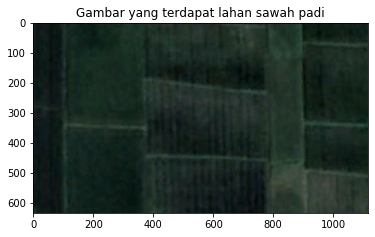

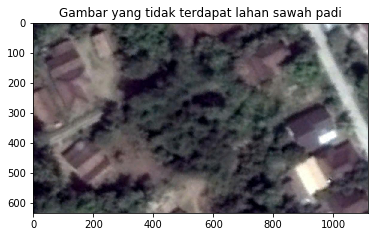

In [5]:
#Gambar yang terdapat lahan sawah padi
plt.title("Gambar yang terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/Jawa/b58.jpg"))
plt.show()

#Gambar yang terdapat tidak lahan sawah padi
plt.title("Gambar yang tidak terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/Sumatra/o125.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. 



In [6]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)

files = os.listdir("data/paddy/train/Jawa")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Jawa"
    file = os.path.join("data/paddy/train/Jawa",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o72_00000.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o72_00001.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o72_00008.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o72_00009.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o72_00010.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/choppe

In [7]:
files = os.listdir("data/paddy/train/Kalimantan")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Kalimantan"
    file = os.path.join("data/paddy/train/Kalimantan",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o90_00005.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o90_00006.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o90_00024.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o90_00042.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/o90_00048.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: 

In [8]:
files = os.listdir("data/paddy/train/Sumatra")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Sumatra"
    file = os.path.join("data/paddy/train/Sumatra",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b104_00000.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b104_00001.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b104_00002.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b104_00003.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b104_00004.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarnin

In [11]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
files = os.listdir("data/paddy/chopped/Jawa")
files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Kalimantan
#files = os.listdir("data/paddy/chopped/Kalimantan")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Sumatra
#files = os.listdir("data/paddy/chopped/Sumatra")
#files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("data/paddy/chopped/Jawa",file)
    #img_path = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path = os.path.join("data/paddy/chopped/Sumatra",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
X = x.reshape(x.shape[0], -1)
Y = np.array(y)
print(X.shape,Y.shape)

files= pd.Index(files)
files.value_counts()

(29700, 9408) (29700,)


o65_00243.jpg    1
o68_00014.jpg    1
b65_00112.jpg    1
b59_00268.jpg    1
o59_00245.jpg    1
                ..
o54_00330.jpg    1
o52_00126.jpg    1
b75_00314.jpg    1
o62_00528.jpg    1
o74_00545.jpg    1
Length: 29700, dtype: int64

In [134]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
#files = os.listdir("data/paddy/chopped/Jawa")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Kalimantan
files = os.listdir("data/paddy/chopped/Kalimantan")
files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Sumatra
#files = os.listdir("data/paddy/chopped/Sumatra")
#files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x1 = []
y1 = []

for file in files:
    if file.startswith("b"):
        label1 = 1
    else:
        label1 = 0
    
    img_path1 = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path1 = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path1 = os.path.join("data/paddy/chopped/Sumatra",file)
    img1 = load_img(img_path1)
    img1 = img_to_array(img1)/255
    x1.append(img1)
    y1.append(label1)

x1 = np.array(x1)
X1 = x1.reshape(x1.shape[0], -1)
Y1 = np.array(y1)
print(X1.shape,Y1.shape)

files= pd.Index(files)
files.value_counts()

(29700, 9408) (29700,)


o100_00455.jpg    1
o100_00457.jpg    1
o92_00191.jpg     1
b79_00223.jpg     1
b76_00169.jpg     1
                 ..
b84_00208.jpg     1
o97_00194.jpg     1
o76_00525.jpg     1
b79_00063.jpg     1
b97_00315.jpg     1
Length: 29700, dtype: int64

In [135]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
#files = os.listdir("data/paddy/chopped/Jawa")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Kalimantan
#files = os.listdir("data/paddy/chopped/Kalimantan")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Sumatra
files = os.listdir("data/paddy/chopped/Sumatra")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x2 = []
y2 = []

for file in files:
    if file.startswith("b"):
        label2 = 1
    else:
        label2 = 0
    
    img_path2 = os.path.join("data/paddy/chopped/Sumatra",file)
    img2 = load_img(img_path2)
    img2 = img_to_array(img2)/255
    x2.append(img2)
    y2.append(label2)

x2 = np.array(x2)
X2 = x2.reshape(x2.shape[0], -1)
Y2 = np.array(y2)
print(X2.shape,Y2.shape)

files= pd.Index(files)
files.value_counts()

(29700, 9408) (29700,)


o114_00382.jpg    1
o110_00242.jpg    1
o118_00059.jpg    1
o104_00135.jpg    1
o115_00088.jpg    1
                 ..
b125_00215.jpg    1
b103_00136.jpg    1
o114_00146.jpg    1
b122_00356.jpg    1
o115_00547.jpg    1
Length: 29700, dtype: int64

In [0]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, test_x, y_train, test_y = train_test_split(X, Y, random_state=0)
X_train1, test_x1, y_train1, test_y1 = train_test_split(X1, Y1, random_state=0)
X_train2, test_x2, y_train2, test_y2 = train_test_split(X2, Y2, random_state=0)

In [164]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)
logreg.fit(X_train1, y_train1)
logreg.fit(X_train2, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# make class predictions for the testing set
y_pred_class = logreg.predict(test_x)
y_pred_class1 = logreg.predict(test_x1)
y_pred_class2 = logreg.predict(test_x2)

In [166]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(test_y, y_pred_class))
print(metrics.accuracy_score(test_y1, y_pred_class1))
print(metrics.accuracy_score(test_y2, y_pred_class2))

0.872996632996633
0.7208080808080808
0.804983164983165


In [167]:
# examine the class distribution of the testing set (using a Pandas Series method)
test_Y = pd.Index(test_y)
test_Y.value_counts()

1    3738
0    3687
dtype: int64

In [174]:
test_Y1 = pd.Index(test_y1)
test_Y1.value_counts()

0    3815
1    3610
dtype: int64

In [169]:
test_Y2 = pd.Index(test_y2)
test_Y2.value_counts()

0    3725
1    3700
dtype: int64

In [175]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
print(test_y.mean())
print(test_y1.mean())
print(test_y2.mean())

0.5034343434343435
0.4861952861952862
0.4983164983164983


In [176]:
# calculate the percentage of zeros
print(1 - test_y.mean())
print(1 - test_y1.mean())
print(1 - test_y2.mean())

0.49656565656565654
0.5138047138047138
0.5016835016835017


In [178]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
print(max(test_y.mean(), 1 - test_y.mean()))
print(max(test_y1.mean(), 1 - test_y1.mean()))
print(max(test_y2.mean(), 1 - test_y2.mean()))

0.5034343434343435
0.5138047138047138
0.5016835016835017


In [179]:
# calculate null accuracy (for multi-class classification problems)
print(test_Y.value_counts().head(1) / len(test_y))
print(test_Y1.value_counts().head(1) / len(test_y1))
print(test_Y2.value_counts().head(1) / len(test_y2))

1    0.503434
dtype: float64
0    0.513805
dtype: float64
0    0.501684
dtype: float64


In [180]:
# print the first 25 true and predicted responses
print('True:', test_Y.values[0:25])
print('False:', y_pred_class[0:25])

print('True:', test_Y1.values[0:25])
print('False:', y_pred_class1[0:25])

print('True:', test_Y2.values[0:25])
print('False:', y_pred_class2[0:25])

True: [1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0]
False: [1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0]
True: [1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1]
False: [1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1]
True: [0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0]
False: [1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0]


In [181]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(test_y, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion1 = metrics.confusion_matrix(test_y1, y_pred_class1)
print(confusion1)
#[row, column]
TP1 = confusion1[1, 1]
TN1 = confusion1[0, 0]
FP1 = confusion1[0, 1]
FN1 = confusion1[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion2 = metrics.confusion_matrix(test_y2, y_pred_class2)
print(confusion2)
#[row, column]
TP2 = confusion2[1, 1]
TN2 = confusion2[0, 0]
FP2 = confusion2[0, 1]
FN2 = confusion2[1, 0]

[[2766  921]
 [  22 3716]]
[[1967 1848]
 [ 225 3385]]
[[2709 1016]
 [ 432 3268]]


In [182]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(test_y, y_pred_class))

print((TP1 + TN1) / float(TP1 + TN1 + FP1 + FN1))
print(metrics.accuracy_score(test_y1, y_pred_class1))

print((TP2 + TN2) / float(TP2 + TN2 + FP2 + FN2))
print(metrics.accuracy_score(test_y2, y_pred_class2))

0.872996632996633
0.872996632996633
0.7208080808080808
0.7208080808080808
0.804983164983165
0.804983164983165


Text(0, 0.5, 'Accuracy')

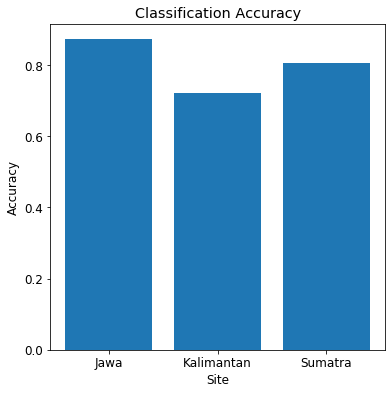

In [183]:
import matplotlib.pyplot as plt

data = {'Jawa': metrics.accuracy_score(test_y, y_pred_class), 'Kalimantan': metrics.accuracy_score(test_y1, y_pred_class1), 'Sumatra': metrics.accuracy_score(test_y2, y_pred_class2)}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
axs.bar(names, values)

plt.title('Classification Accuracy')
plt.xlabel('Site')
plt.ylabel('Accuracy')

In [184]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(test_y, y_pred_class))

classification_error1 = (FP1 + FN1) / float(TP1 + TN1 + FP1 + FN1)

print(classification_error1)
print(1 - metrics.accuracy_score(test_y1, y_pred_class1))

classification_error = (FP2 + FN2) / float(TP2 + TN2 + FP2 + FN2)

print(classification_error)
print(1 - metrics.accuracy_score(test_y2, y_pred_class2))

0.127003367003367
0.127003367003367
0.2791919191919192
0.2791919191919192
0.195016835016835
0.19501683501683498


In [186]:
recall_rate_sawah = TP / float(FN + TP)

print(recall_rate_sawah)
print(metrics.recall_score(test_y, y_pred_class))

recall_rate_sawah1 = TP1 / float(FN1 + TP1)

print(recall_rate_sawah1)
print(metrics.recall_score(test_y1, y_pred_class1))

recall_rate_sawah2 = TP2 / float(FN2 + TP2)

print(recall_rate_sawah2)
print(metrics.recall_score(test_y2, y_pred_class2))

0.9941144997324772
0.9941144997324772
0.9376731301939059
0.9376731301939059
0.8832432432432432
0.8832432432432432


Text(0, 0.5, 'Recall Rate')

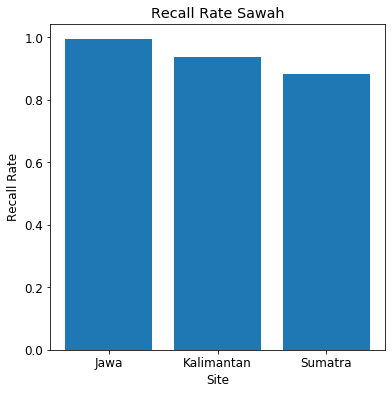

In [187]:
import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_sawah, 'Kalimantan': recall_rate_sawah1, 'Sumatra': recall_rate_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [188]:
recall_rate_bukan_sawah = TN / (TN + FP)

print(recall_rate_bukan_sawah)

recall_rate_bukan_sawah1 = TN1 / (TN1 + FP1)

print(recall_rate_bukan_sawah1)

recall_rate_bukan_sawah2 = TN2 / (TN2 + FP2)

print(recall_rate_bukan_sawah2)

0.7502034174125305
0.5155963302752293
0.727248322147651


Text(0, 0.5, 'Recall Rate')

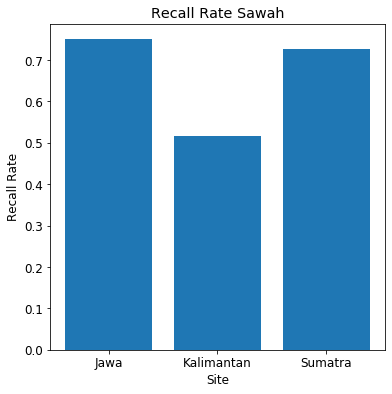

In [189]:
import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_bukan_sawah, 'Kalimantan': recall_rate_bukan_sawah1, 'Sumatra': recall_rate_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [191]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - recall_rate_bukan_sawah)

false_positive_rate1 = FP1 / float(TN1 + FP1)

print(false_positive_rate1)
print(1 - recall_rate_bukan_sawah1)

false_positive_rate2 = FP2 / float(TN2 + FP2)

print(false_positive_rate2)
print(1 - recall_rate_bukan_sawah2)

0.24979658258746948
0.2497965825874695
0.48440366972477067
0.48440366972477067
0.272751677852349
0.272751677852349


In [193]:
precision_sawah = TP / float(TP + FP)

print(precision_sawah)
print(metrics.precision_score(test_y, y_pred_class))

precision_sawah1 = TP1 / float(TP1 + FP1)

print(precision_sawah1)
print(metrics.precision_score(test_y1, y_pred_class1))

precision_sawah2 = TP2 / float(TP2 + FP2)

print(precision_sawah2)
print(metrics.precision_score(test_y2, y_pred_class2))

0.8013802027172741
0.8013802027172741
0.6468564876743742
0.6468564876743742
0.7628384687208216
0.7628384687208216


Text(0, 0.5, 'Recall Rate')

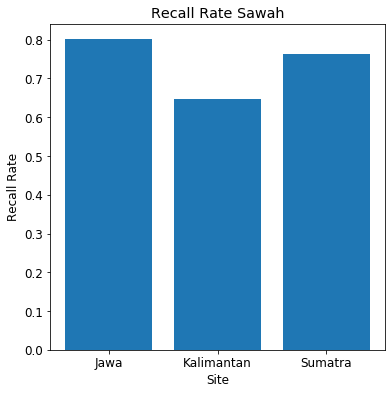

In [194]:
import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_sawah, 'Kalimantan': precision_sawah1, 'Sumatra': precision_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [195]:
precision_bukan_sawah = TN / (FP + TP)

print(precision_bukan_sawah)

precision_bukan_sawah1 = TN1 / (FP1 + TP1)

print(precision_bukan_sawah1)

precision_bukan_sawah2 = TN2 / (FP2 + TP2)

print(precision_bukan_sawah2)

0.5965063618719
0.37588381425568507
0.6323529411764706


Text(0, 0.5, 'Recall Rate')

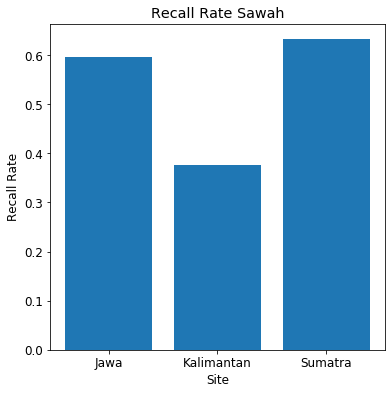

In [196]:
import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_bukan_sawah, 'Kalimantan': precision_bukan_sawah1, 'Sumatra': precision_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [0]:
#from sklearn.model_selection import train_test_split

#x_train, valid_x, y_train, valid_y = train_test_split(x,Y,test_size=0.0008,stratify = y)

#print("Bentuk array dari dataset train (pelatihan) adalah:",x_train.shape,y_train.shape)
#print("Bentuk array dari dataset validation adalah:",valid_x.shape,valid_y.shape)
#print("Bentuk array dari dataset test (pengujian) adalah:",x_test.shape,y_test.shape)

In [0]:
#compute class weight
#print(np.unique(train_y,return_counts=True))
#print(np.unique(valid_y,return_counts=True))

#cw = compute_class_weight("balanced",np.unique(train_y),train_y)
#print(cw)

In [197]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

IMAGE_SIZE = 56
BATCH_SIZE = 2000
base_dir = os.path.join('data/paddy/chopped')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.00029)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", x_test.shape,y_test.shape)

Found 89076 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (2000, 56, 56, 3) (2000, 3)
Bentuk array dari dataset validation (validasi) adalah: (24, 56, 56, 3) (24, 3)
Bentuk array dari dataset test (pengujian) adalah: (24, 56, 56, 3) (24,)


In [198]:
#Memuat dataset pengujian

X_test = []
Y_test = []
labels1 = ['Jawa', 'Kalimantan', 'Sumatra']

for i,label1 in enumerate(labels1):
    folder1 = os.path.join("data/paddy/test",label1)
    files1 = os.listdir(folder1)
    files1 = [x for x in files1 if x.endswith(".jpg")]
    for k,file in enumerate(files1):
        image_path1 = os.path.join(folder1, file)   
        image1 = imread(image_path1)/255.
        image1 = resize(image1,(56,56))
        X_test.append(image1)
        category = os.path.split(folder1)[-1]
        Y_test.append(i)

x_test = np.array(X_test)
y_test = np.array(Y_test)
print(x_test.shape,y_test.shape)

print(folder1)
print(files1)

(24, 56, 56, 3) (24,)
data/paddy/test/Sumatra
['p100_sumatra4.jpg', 'np100_sumatra2.jpg', 'np100_sumatra3.jpg', 'p100_sumatra3.jpg', 'p100_sumatra1.jpg', 'np100_sumatra1.jpg', 'np100_sumatra4.jpg', 'p100_sumatra2.jpg']


# Menyimpan Label

In [199]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Jawa': 0, 'Kalimantan': 1, 'Sumatra': 2}


In [200]:
!cat labels.txt

Jawa
Kalimantan
Sumatra

# Membuat Pemodelan dan Pelatihan Model

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

#Pembuatan Model


# Mengelompokkan Klasifikasi Tiga Pulau dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan Pengujian

In [0]:
y_test2 = to_categorical(y_test)
x_test3, y_test3 = (x_test, y_test2)

In [203]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    tf.keras.layers.Dense(3),
    tf.keras.layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 16)        448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D

In [204]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint 

#Menyimpan model bobot yang terbaik selama training
#ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=20, 
                    validation_data=val_generator)
#history = model.fit(train_x,train_y,batch_size=200,epochs=100,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])

Epoch 1/20
45/45 [==============================] - 29s 642ms/step - loss: 0.5688 - acc: 0.7023 - val_loss: 0.3384 - val_acc: 0.7778
Epoch 2/20
45/45 [==============================] - 22s 485ms/step - loss: 0.3563 - acc: 0.8420 - val_loss: 0.1722 - val_acc: 1.0000
Epoch 3/20
45/45 [==============================] - 22s 494ms/step - loss: 0.3186 - acc: 0.8636 - val_loss: 0.1563 - val_acc: 0.9861
Epoch 4/20
45/45 [==============================] - 22s 486ms/step - loss: 0.2864 - acc: 0.8793 - val_loss: 0.1370 - val_acc: 0.9861
Epoch 5/20
45/45 [==============================] - 22s 481ms/step - loss: 0.2614 - acc: 0.8911 - val_loss: 0.0991 - val_acc: 1.0000
Epoch 6/20
45/45 [==============================] - 22s 489ms/step - loss: 0.2484 - acc: 0.8956 - val_loss: 0.1067 - val_acc: 1.0000
Epoch 7/20
45/45 [==============================] - 22s 489ms/step - loss: 0.2381 - acc: 0.8990 - val_loss: 0.0765 - val_acc: 1.0000
Epoch 8/20
45/45 [==============================] - 22s 483ms/step - 

#Menggambarkan Hasil Pelatihan

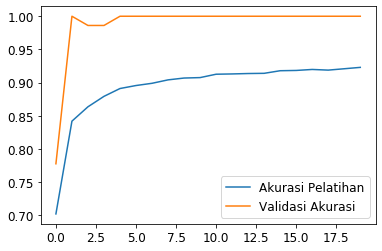

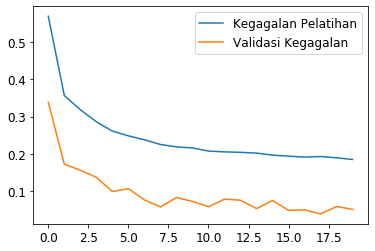

In [205]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluasi Gambar Pelatihan dengan Gambar Test data

In [206]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi test data
#print(model.evaluate(x= x_test3, y = y_test3))

['loss', 'acc']
45/45 [==============================] - 21s 462ms/step - loss: 0.1799 - acc: 0.9255
[0.17987014220820532, 0.9254719]
1/1 [==============================] - 0s 21ms/step - loss: 0.0512 - acc: 1.0000
[0.0511937253177166, 1.0]
24/24 [==============================] - 0s 113us/sample - loss: 1.0807 - acc: 0.6528
[1.0807132720947266, 0.6527778]


In [207]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
[1 1 0 1 2 0 0 0 1 1 1 1 1 0 2 1 1 0 0 1 1 0 0 1]


Normalized confusion matrix
[[0.5  0.38 0.12]
 [0.12 0.75 0.12]
 [0.5  0.5  0.  ]]


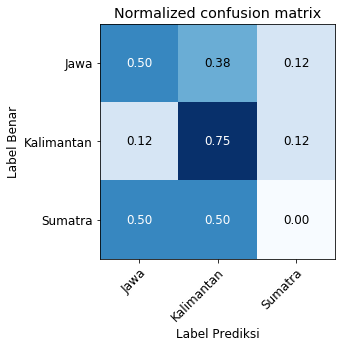

In [209]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels1, normalize=True,
                      title='Normalized confusion matrix')

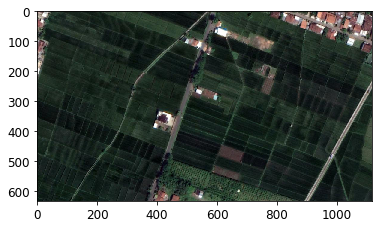

27
1296 27 48


In [210]:
#Membaca Gambar Test Data dan Menampilkannya
img_path = "data/paddy/test/test_image/test_image2.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

In [223]:
print(patches.shape)

(1296, 56, 56, 3)


#Prediksi Gambar Individual

In [221]:
#Memprediksi probalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
plt.imshow(paddy,cmap="jet")

ValueError: ignored

**Catatan** :
Bahwa setiap gambar sesuai dengan 1 piksel dari probabilitasnya, dan ukurannya tidak kompatibel dengan gambar input.
Oleh karena itu peneliti akan menghitung faktor rasio dan mengubah ukurannya

In [0]:
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))

print(zoomed.shape)

In [0]:
#Menampilkan hasil gambar level tertentu
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

#Menampilkan Luas Lahan Sawah yang berwarna Merah


In [0]:
plt.imshow(zoomed,alpha=1,vmax=1.0,vmin=0,cmap="jet")

#Menghitung luas Sawah 


In [0]:
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed :", np.min(zoomed))
print("Maximal level zoomed :", np.max(zoomed))

In [0]:
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized = (zoomed-np.min(zoomed))/(np.max(zoomed)-np.min(zoomed))
print("Minimal level ternomalisasi:", np.min(normalized))
print("Maximal level ternomalisasi:", np.max(normalized))

In [0]:
#Menghitung luas lahan sawah dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sawah adalah 0.5 (Nilai diantara 0 dan 1)
luaspiksel=(normalized>0.5).sum()
akurasi=((normalized>0.5).sum()*100/(normalized<1).sum())
print("Luas lahan sawah dalam piksel :", (luaspiksel))
print("akurasi dalam piksel :", (akurasi))

**"Validasi Nilai Piksel ke dalam Meter"**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/zoomed%20gambar.jpg)

Dapat dilakukan dengan cara :
1.   Menzoom/memperbesar sampel gambar (sampai batas maksimum).
2.   Menghitung jumlah piksel, sebagai contoh pada objek Bus. Diketahui pada umumnya Bus memiliki lebar sebesar 2,5 Meter. [Resolusi Gambar adalah 1116x632 piksel]
3.   Kalkulasi nilai lebar Bus dalam piksel, disini berjumlah 8 piksel. Lalu dilakukan perhitungan sebagai berikut :
    *   Nilai Meter/Piksel(**M/P**) = **M**(meter) / **P**(piksel)
                           = 2,5 meter / 8 piksel
                           = 0,3125 m/p 
                           ~= 0,3 m/p

Maka konversi 1 piksel menjadi meter pada gambar ini sebesar 0,3 

Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09



**Atau dengan pembanding validitas lainnya, yaitu menggunakan software Google Earth**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/google%20earth.jpg)

Disini diketahui :
*   Jumlah piksel pada garis berwarna kuning adalah 42 piksel
*   Panjang garis berwarna kuning adalah 14,5 meter

Dengan cara yang sama seprti sebelumnya :
 
 dilakukan perhitungan sebagai berikut :

    *   Nilai Meter/Piksel(M/P) = M(meter) / P(piksel)
                           = 14,5 meter / 42 piksel
                           = 0,323 m/p 
                           ~= 0,3 m/p

In [0]:
#Setelah diketahui luas sawah dalam piksel, kemudian menkonversi dalam meter dan hektar
#Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09 
luasmtr = 0.1089*(luaspiksel)
luasha = (luasmtr)/10000
print("Luas lahan sawah dalam meter persegi :", (luasmtr))
print("Luas lahan sawah dalam hektar :", (luasha))